In [53]:
from pathlib import Path
import os

dataset_path = Path("eye_tracking")

датасет имеет несложную структуру - в основной директории находятся 5 субдиректорий с изображениями, помеченными как классы направления взгляда участников
аннотаций к изображениям не представляется
есть проблема - наименование файлов оставляет желать лучшего, так что нужно сначала разобраться с этим
еще я думаю стоит обернуть это все в пары ключ значение

In [54]:
data = []

try:
    for dir in dataset_path.iterdir():
        if dir.is_dir():
            class_name = dir.name
            for idx, image_path in enumerate(sorted(dir.glob("*.jpg"))):
                new_image_name = f"{class_name}_{idx}{image_path.suffix}"

                # image_path.rename(image_path.parent / new_image_name)
                data.append({
                    'image_path': str(image_path),
                    'label': class_name
                })
                
except FileExistsError as e:
    print(f"{e}")

готово!
теперь можно приступать к разбиению классов в таблицу dataframe, с ней и будем анализировать данные

In [55]:
import pandas as pd

df = pd.DataFrame(data)
print(df)
print(f"всего фоток: {len(df)}")
print(f"колво меток классов: {df['label'].value_counts()}")
print(f"{df.isna().sum()}")

                           image_path label
0        eye_tracking\down\down_0.jpg  down
1        eye_tracking\down\down_1.jpg  down
2       eye_tracking\down\down_10.jpg  down
3      eye_tracking\down\down_100.jpg  down
4     eye_tracking\down\down_1000.jpg  down
...                               ...   ...
7495       eye_tracking\up\up_995.jpg    up
7496       eye_tracking\up\up_996.jpg    up
7497       eye_tracking\up\up_997.jpg    up
7498       eye_tracking\up\up_998.jpg    up
7499       eye_tracking\up\up_999.jpg    up

[7500 rows x 2 columns]
всего фоток: 7500
колво меток классов: label
down        1500
left        1500
right       1500
straight    1500
up          1500
Name: count, dtype: int64
image_path    0
label         0
dtype: int64


в целом датасет чистенький! можно создать пару графиков для того чтобы убедиться
например будет неплохим вариантом сделать график распределения классов, хоть там и равное кол-во изображений

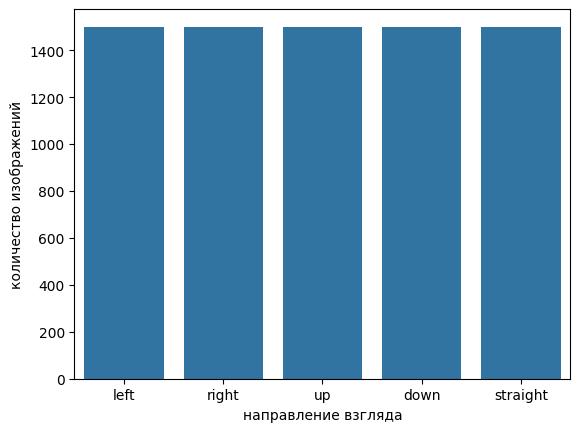

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(df, x='label', order=['left', 'right', 'up', 'down', 'straight'])
plt.xlabel('направление взгляда')
plt.ylabel('количество изображений')
plt.show()

также можно сделать примеры изображений для каждого класса меток

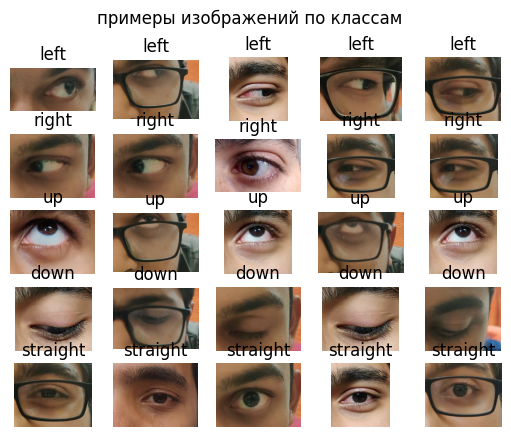

In [57]:
fig, axes = plt.subplots(5, 5)
fig.suptitle('примеры изображений по классам')

for idx, label in enumerate(['left', 'right', 'up', 'down', 'straight']):
    class_images = df[df['label'] == label].sample(5)
    for i, (_, row) in enumerate(class_images.iterrows()):
        img = plt.imread(row['image_path'])
        axes[idx, i].imshow(img)
        axes[idx, i].set_title(label)
        axes[idx, i].axis('off')
plt.show()


разное разрешение у изображений решится приведением к 224x224 с помощью transforms, встроенный в pytorch

In [58]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 
import torchvision.transforms as transforms

BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
]) # теперь изображение это тензор

final_dataset = ImageFolder(root=dataset_path, transform=transform)

# проверка что все нормик
print(final_dataset.classes)
print(final_dataset.class_to_idx)
print(final_dataset.samples[:3])
print(len(final_dataset))

['down', 'left', 'right', 'straight', 'up']
{'down': 0, 'left': 1, 'right': 2, 'straight': 3, 'up': 4}
[('eye_tracking\\down\\down_0.jpg', 0), ('eye_tracking\\down\\down_1.jpg', 0), ('eye_tracking\\down\\down_10.jpg', 0)]
7500


теперь можно спокойно разделять на выборки для тренировки, оценки и тестирования, но в другом файле
